In [2]:
!git clone https://github.com/rpathak38/DL_Proj


fatal: destination path 'DL_Proj' already exists and is not an empty directory.


In [3]:
cd /content/DL_Proj

/content/DL_Proj


In [4]:
%load_ext autoreload
%autoreload 1
import urllib.request
import tarfile
import numpy as np
import random
import os
import torch
from PIL import Image
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unet import UNet
from tqdm import tqdm
from metrics_loss import dice_index, class_balanced_focal_ce_loss

In [5]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. If you are using CUDA, set also the seed for it and enable deterministic behavior
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU.
    # Below two lines ensure deterministic behavior, but may lead to slower training
    # due to the need to find algorithms that have deterministic behavior.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# Check if CUDA is available
# Regardless of whether or not you are using GPU create the no gpu environment for now
is_cuda_available = torch.cuda.is_available()

# Print the status of CUDA availability
print("CUDA Available:", is_cuda_available)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print the device being used
print("Using device:", device)

CUDA Available: True
Using device: cuda


In [7]:
data_dir = "data"
aug_data_dir = "sbd_dat_mat"
large_dataset = False # set to false if you want small dataset (0k images vs 10k images)
download = True # specify true if you want to download data

In [8]:
if download is True:
    os.makedirs(data_dir, exist_ok=True)

    voc_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
    voc_name = "pascal_voc.tar"
    voc_name = os.path.join(data_dir, voc_name)

    urllib.request.urlretrieve(voc_url, voc_name)

    with tarfile.open(voc_name) as tar:
        tar.extractall(path=data_dir)

In [9]:
# Augmentations dataset. This is a large dataset. Don't download unless you are planning on doing full training.
if large_dataset is True:
    aug_data_dir = "sbd_dat_mat"
    os.makedirs(aug_data_dir, exist_ok=True)

    aug_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
    aug_name = os.path.join(aug_data_dir, 'sbd_aug.tar')

    # Downloading the file from the URL
    urllib.request.urlretrieve(aug_url, aug_name)

    with tarfile.open(aug_name) as tar:
        tar.extractall(path=aug_data_dir)

In [10]:
from data_loader import pascalVOCLoader
from augmentations import *

# motivation for cropping instead of resizing: https://github.com/VainF/DeepLabV3Plus-Pytorch
img_size = 256 # pass in your image size
resize = "resize" # choose resizing method, "random_crop" which takes a random crop from the image, or use "resize" which scales the image down
# random crop preserves pixel level info while losing the whole picture, while resize keeps the whole picture, but may distort pixel level info

if resize == "random_crop":
    aug_list = Compose([RandomCrop(img_size)])
    img_size = "same"
else:
    aug_list = Compose([])

pascal_original = os.path.join(data_dir, "VOCdevkit/VOC2012")
if large_dataset is True:
    pascal_augment = os.path.join(aug_data_dir, "benchmark_RELEASE")
    split_train = "train_aug"
    split_val = "train_aug_val"
else:
    pascal_augment = None
    split_train = "train"
    split_val = "val"
train_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_train, is_transform=True, img_size=img_size, augmentations=aug_list)
val_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_val, is_transform=True, img_size=img_size, augmentations=aug_list)
# After this cell runs, switch to gpu environment if desired. Comment out dataset download code before running (above two cells).

Using small dataset (Pascal VOC)
Using small dataset (Pascal VOC)


In [11]:
freq = torch.zeros(len(train_dataset.get_pascal_labels()))
total = torch.zeros(1)
for img, mask in train_dataset:
    indices, counts = mask.unique(return_counts=True)
    for index, count in zip(indices, counts):
        freq[index] += count
    total += sum(counts)
freq = freq / total
print(freq)

tensor([0.7490, 0.0070, 0.0028, 0.0082, 0.0059, 0.0058, 0.0169, 0.0136, 0.0256,
        0.0110, 0.0080, 0.0124, 0.0161, 0.0089, 0.0108, 0.0457, 0.0062, 0.0085,
        0.0138, 0.0152, 0.0086])


In [12]:
class_weights = 1/freq
print(class_weights)

tensor([  1.3350, 142.0824, 354.8448, 121.6011, 170.6002, 173.5987,  59.1748,
         73.4235,  39.0592,  91.2982, 124.5666,  80.3877,  62.1089, 112.9127,
         92.2138,  21.8766, 161.7523, 118.2453,  72.5260,  65.9312, 116.1235])


In [13]:
from torch.utils.data import DataLoader

# DataLoader parameters
batch_size = 8  # You can adjust this depending on your GPU memory
shuffle = True   # Shuffles the dataset at every epoch
num_workers = 4  # Number of worker threads for loading data

# Create the DataLoaders for our training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
vis_length = 5
imgs = []
masks = []
for img, mask in train_loader:
    imgs.append(train_dataset.unnormalize(img[0]))
    print(mask[0].unique())
    print(mask[0].shape)
    mask_decoded = train_dataset.decode_segmap(mask[0].numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    if len(imgs) == vis_length:
        break
print(imgs[0].shape)
print(masks[0].shape)

tensor([ 0, 19])
torch.Size([256, 256])
tensor([ 0, 12, 15, 17])
torch.Size([256, 256])
tensor([0, 1])
torch.Size([256, 256])
tensor([ 0,  7, 15])
torch.Size([256, 256])
tensor([ 0, 13])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


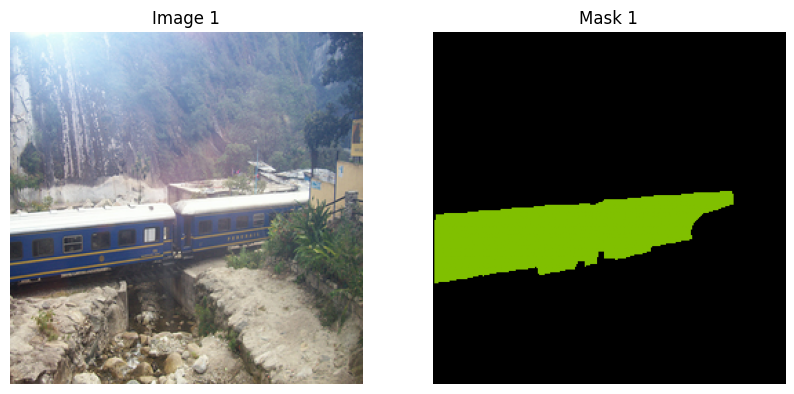

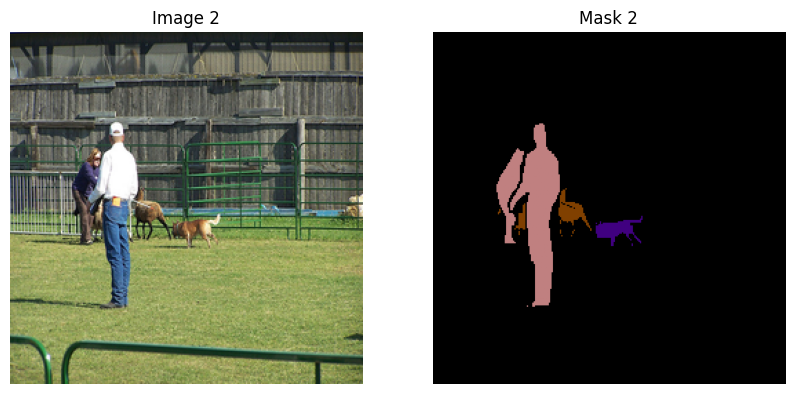

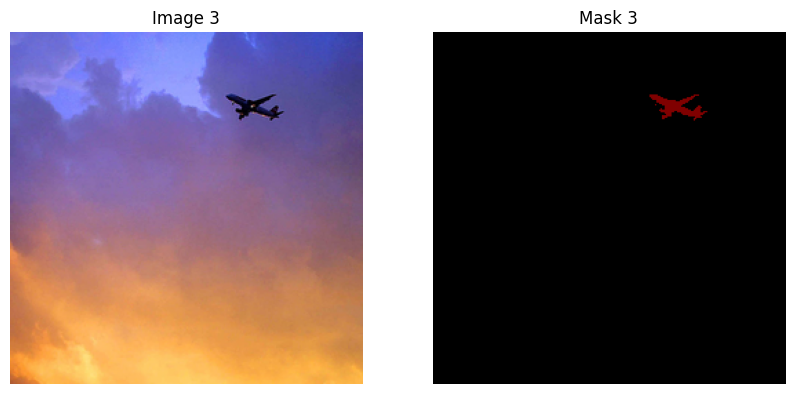

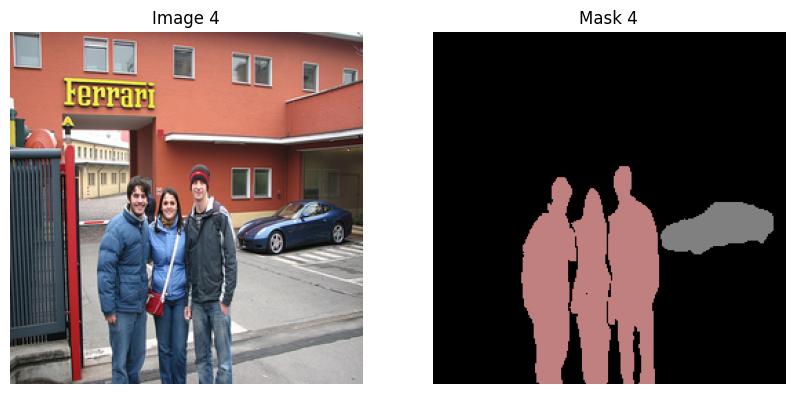

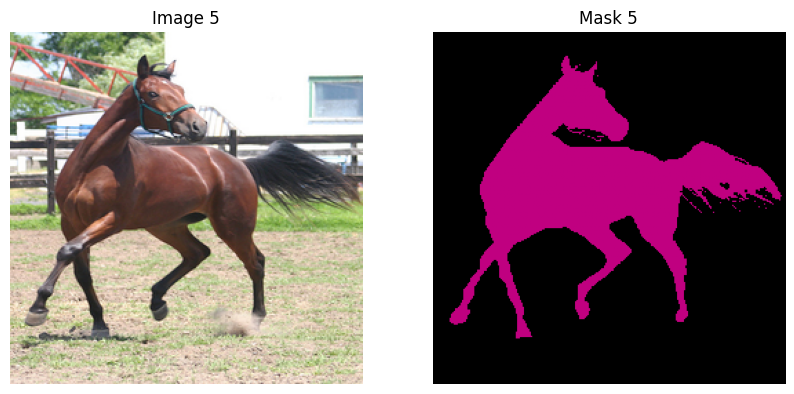

In [15]:
def visualize_image_and_mask_tensors(image_tensors, mask_tensors):
    """
    Visualize lists of image tensors and their corresponding mask tensors as regular images.

    Parameters:
        image_tensors (list of torch.Tensor): The list of image tensors to visualize.
        mask_tensors (list of torch.Tensor): The list of mask tensors to visualize.
    """
    for i, (image_tensor, mask_tensor) in enumerate(zip(image_tensors, mask_tensors)):
        # Convert the image tensor to numpy and change to HWC format for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Convert the mask tensor to numpy and change to HWC format for visualization
        mask_np = mask_tensor.permute(1, 2, 0).numpy()

        # Display the image and the mask side by side
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        plt.show()

# For testing, let's use the same image tensors and mask tensors as regular three-channel images
# We'll use the previously defined image_tensors and create new mask_tensors with 3 channels
mask_tensors = [torch.rand(3, 100, 100), torch.rand(3, 100, 100)]

# Test the function
visualize_image_and_mask_tensors(imgs, masks)

In [16]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
model = UNet(3, 21, [64, 128, 256, 512])

# Move the model to the CUDA device if available
model = model.to(device)
class_weights = 1/freq
class_weights = class_weights.to(device)

epochs = 10
lr = 0.1
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Using device: cuda


In [17]:
# Training and validation code
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    model.train()
    batch_loss = batch_acc = 0.0

    for img, mask in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = model(img)
        loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            accuracy = dice_index(outs, mask)
            batch_loss += loss.item()
            batch_acc += accuracy.item()

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_acc}")
    model.eval()
    val_loss = val_acc = 0.0

    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = img.to(device), mask.to(device)

            outs = model(img)
            loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

EPOCH 0:


Training Loop, Epoch: 0: 100%|██████████| 183/183 [01:09<00:00,  2.64it/s]


Training loss: 0.4143687904776771, Training accuracy: 0.057770461169748356


Validation Loop, Epoch: 0: 100%|██████████| 182/182 [00:23<00:00,  7.72it/s]


Validation loss: 0.029412981337652758, Validation accuracy: 0.058296926299130525
EPOCH 1:


Training Loop, Epoch: 1: 100%|██████████| 183/183 [01:02<00:00,  2.93it/s]


Training loss: 0.017203537131471387, Training accuracy: 0.05813704685516696


Validation Loop, Epoch: 1: 100%|██████████| 182/182 [00:23<00:00,  7.79it/s]


Validation loss: 0.01081741107678921, Validation accuracy: 0.058296858855001216
EPOCH 2:


Training Loop, Epoch: 2: 100%|██████████| 183/183 [01:02<00:00,  2.94it/s]


Training loss: 0.007626141836266211, Training accuracy: 0.05813683929746268


Validation Loop, Epoch: 2: 100%|██████████| 182/182 [00:23<00:00,  7.65it/s]


Validation loss: 0.005795597635109776, Validation accuracy: 0.058297200906243955
EPOCH 3:


Training Loop, Epoch: 3: 100%|██████████| 183/183 [01:02<00:00,  2.93it/s]


Training loss: 0.0046350668569965685, Training accuracy: 0.05813673545754021


Validation Loop, Epoch: 3: 100%|██████████| 182/182 [00:24<00:00,  7.50it/s]


Validation loss: 0.003838346659904346, Validation accuracy: 0.05829699595387165
EPOCH 4:


Training Loop, Epoch: 4: 100%|██████████| 183/183 [01:02<00:00,  2.93it/s]


Training loss: 0.0029861008445605064, Training accuracy: 0.05813679660930008


Validation Loop, Epoch: 4: 100%|██████████| 182/182 [00:24<00:00,  7.53it/s]


Validation loss: 0.002556629295833153, Validation accuracy: 0.05829688042893515
EPOCH 5:


Training Loop, Epoch: 5: 100%|██████████| 183/183 [01:02<00:00,  2.93it/s]


Training loss: 0.0021516566792670944, Training accuracy: 0.05813683589788082


Validation Loop, Epoch: 5: 100%|██████████| 182/182 [00:23<00:00,  7.68it/s]


Validation loss: 0.0018852213875756466, Validation accuracy: 0.058296844158526304
EPOCH 6:


Training Loop, Epoch: 6: 100%|██████████| 183/183 [01:02<00:00,  2.91it/s]


Training loss: 0.0015652694641116274, Training accuracy: 0.05813655937141408


Validation Loop, Epoch: 6: 100%|██████████| 182/182 [00:23<00:00,  7.75it/s]


Validation loss: 0.001432807008693619, Validation accuracy: 0.058296844158526304
EPOCH 7:


Training Loop, Epoch: 7: 100%|██████████| 183/183 [01:02<00:00,  2.93it/s]


Training loss: 0.0012239228733344502, Training accuracy: 0.05813655928998697


Validation Loop, Epoch: 7: 100%|██████████| 182/182 [00:23<00:00,  7.58it/s]


Validation loss: 0.0011311667624465701, Validation accuracy: 0.05829684428133807
EPOCH 8:


Training Loop, Epoch: 8: 100%|██████████| 183/183 [01:02<00:00,  2.93it/s]


Training loss: 0.0009704451539484998, Training accuracy: 0.058136559351057306


Validation Loop, Epoch: 8: 100%|██████████| 182/182 [00:24<00:00,  7.53it/s]


Validation loss: 0.0009123546358071277, Validation accuracy: 0.05829684536617536
EPOCH 9:


Training Loop, Epoch: 9: 100%|██████████| 183/183 [01:02<00:00,  2.94it/s]


Training loss: 0.0007879774201002298, Training accuracy: 0.05813655924927341


Validation Loop, Epoch: 9: 100%|██████████| 182/182 [00:24<00:00,  7.56it/s]

Validation loss: 0.0007484044561771533, Validation accuracy: 0.058296846553355784


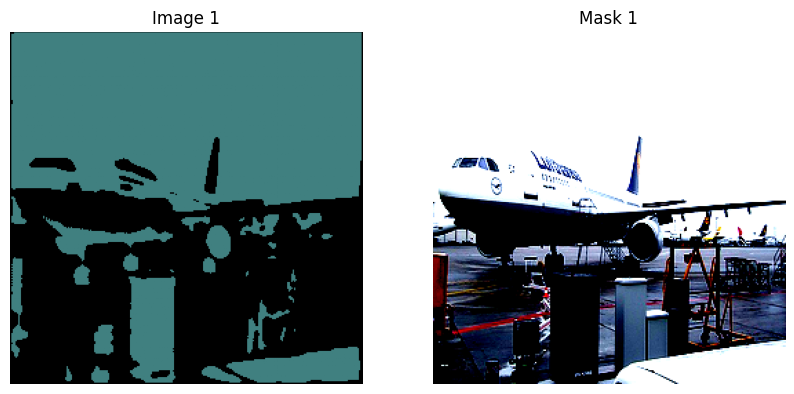

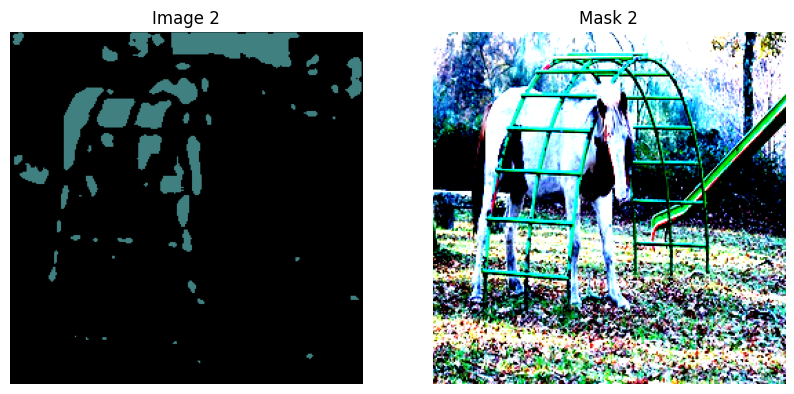

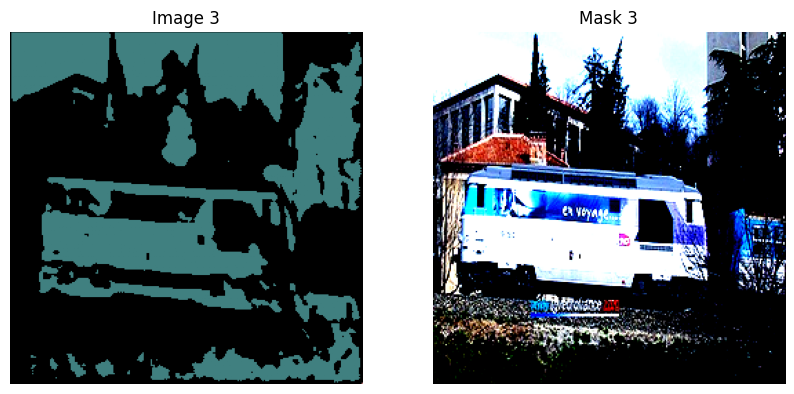

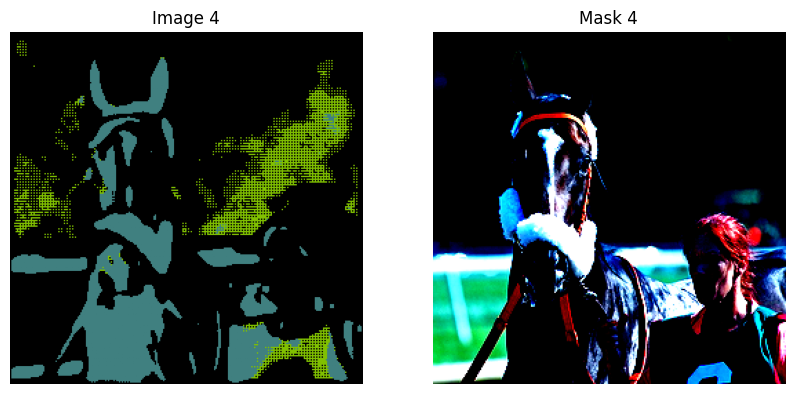

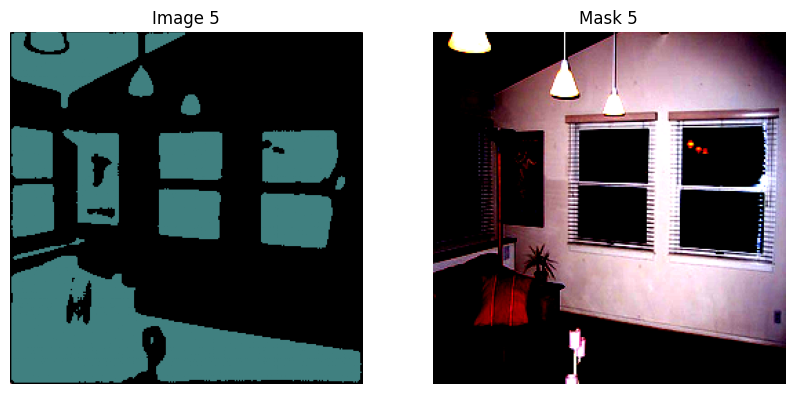

In [20]:
vis_length = 5
imgs = []
masks = []
model = model.to('cpu')
for index, (img, mask) in enumerate(val_loader):
    img = img[0].unsqueeze(0)
    mask = mask[0]
    outs = model(img)  # (NCHW)
    outs = torch.argmax(outs, dim=1)  # NHW
    outs = outs.squeeze(0)
    #print(index, torch.unique(outs, return_counts=True))
    #print(index, torch.unique(mask, return_counts=True))
    mask_decoded = val_dataset.decode_segmap(mask.numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    #print(img.shape)
    masks.append(img.squeeze(0))
    outs_decoded = val_dataset.decode_segmap(outs.numpy())
    imgs.append(torch.tensor(outs_decoded).permute(2, 0, 1))
    if len(imgs) == 5:
        break
visualize_image_and_mask_tensors(imgs, masks)

In [50]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [51]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [52]:
## CHANGE DOWNLOAD TO TRUE, IF RUNNING FOR FIRST TIME!
voc_train = datasets.VOCSegmentation(root='./data',
                                     year='2012',
                                     image_set='train',
                                     download=True,
                                     transform=transform,
                                     target_transform=target_transform)

voc_val = datasets.VOCSegmentation(root='./data',
                                   year='2012',
                                   image_set='val',
                                   download=True,
                                   transform=transform,
                                   target_transform=target_transform)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [53]:
train_loader = torch.utils.data.DataLoader(voc_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(voc_val, batch_size=16, shuffle=False)

In [56]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # Register mean and std as buffers
        self.register_buffer('mean', mean.reshape(1, -1, 1, 1))
        self.register_buffer('std', std.reshape(1, -1, 1, 1))

    def forward(self, x):
        return (x - self.mean) / self.std


class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, last=False):
        super().__init__()
        if last is False:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Sigmoid()
            )

    def forward(self, x):
        # x should (N, C, H, W)
        return self.double_conv(x)


class UNet(nn.Module):
    """Unet inspired architecture.
    Using same convolutions, with output channels being equal to the number of classes. Adding instead of
    appending. Upsampling with MaxUnpooling instead of transpose convolutions.

    Attributes:
        in_channels: The number of input channels.
        out_channels: The number of output classes (including background).
        channel_list: A list representing the intermediate channels that we have. The bottleneck (bottom of the U) outputs 2 * the last channel.
    """

    def __init__(self, in_channels, out_channels, channel_list, means=None, stds=None):
        super().__init__()
        if means is None:
            means = torch.tensor([0.0 for _ in range(in_channels)])
        if stds is None:
            stds = torch.tensor([1.0 for _ in range(in_channels)])
        self.normalize = Normalize(mean=means, std=stds)
        self.downs = nn.ModuleList()
        curr_channel = in_channels
        for intermediate_channel in channel_list:
            self.downs.append(DoubleConv(curr_channel, intermediate_channel, intermediate_channel))
            curr_channel = intermediate_channel

        self.bottleneck = DoubleConv(curr_channel, curr_channel * 2, curr_channel)

        self.ups = nn.ModuleList()
        for i in reversed(range(len(channel_list))):
            if i - 1 < 0:
                self.ups.append(DoubleConv(channel_list[i], channel_list[i], out_channels, last=True))
            else:
                self.ups.append(DoubleConv(channel_list[i], channel_list[i], channel_list[i - 1]))
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        x = self.normalize(x)
        pool_outs = []
        down_activations = []
        for down in self.downs:
            x = down(x)
            down_activations.append(x)

            x, indices = self.pool(x)
            pool_outs.append(indices)

        x = self.bottleneck(x)
        for index, up in enumerate(self.ups):
            x = self.unpool.forward(x, pool_outs[-index - 1])
            temp = x + down_activations[-index - 1]
            x = up(temp)
        return x


In [57]:

def calculate_iou(outputs, labels):
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou = torch.sum(intersection) / torch.sum(union)
    return iou.item()

In [58]:
# Define your UNet model
in_channels = 3  # Assuming RGB images
out_channels = 21  # Number of classes in Pascal VOC
channel_list = [64, 128, 256, 512]  # Adjust as needed
model = UNet(in_channels, out_channels, channel_list)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10  # Adjust as needed
# writer = SummaryWriter()  # For TensorBoard logging
global_step = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(1).long())  # Assuming labels are 3D (batch_size, 1, height, width)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate IoU
        outputs = torch.argmax(outputs, dim=1)
        iou = calculate_iou(outputs, labels.squeeze(1).long())
        total_iou += iou

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_loss}, Average Training IoU: {avg_iou}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc=f'Validation'):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels.squeeze(1).long()).item()

            # Calculate IoU
            val_outputs = torch.argmax(val_outputs, dim=1)
            iou = calculate_iou(val_outputs, val_labels.squeeze(1).long())
            val_iou += iou

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {avg_val_loss}, Average Validation IoU: {avg_val_iou}')

Epoch 1/10: 100%|██████████| 92/92 [00:58<00:00,  1.56it/s]


Epoch 1/10, Average Training Loss: 2.967303314934606, Average Training IoU: 0.08891051262617111


Validation: 100%|██████████| 91/91 [00:24<00:00,  3.72it/s]


Epoch 1/10, Average Validation Loss: 2.9281010575346893, Average Validation IoU: 0.09917412845643012


Epoch 2/10: 100%|██████████| 92/92 [00:57<00:00,  1.59it/s]


Epoch 2/10, Average Training Loss: 2.9129358892855435, Average Training IoU: 0.10751303868449252


Validation: 100%|██████████| 91/91 [00:24<00:00,  3.69it/s]


Epoch 2/10, Average Validation Loss: 2.8941874346890293, Average Validation IoU: 0.11760552391246125


Epoch 3/10: 100%|██████████| 92/92 [00:57<00:00,  1.59it/s]


Epoch 3/10, Average Training Loss: 2.8647021418032437, Average Training IoU: 0.12080531486350557


Validation: 100%|██████████| 91/91 [00:24<00:00,  3.68it/s]


Epoch 3/10, Average Validation Loss: 2.8102370487464654, Average Validation IoU: 0.1301253956261572


Epoch 4/10: 100%|██████████| 92/92 [00:57<00:00,  1.59it/s]


Epoch 4/10, Average Training Loss: 2.821193381496098, Average Training IoU: 0.12459558199929155


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.62it/s]


Epoch 4/10, Average Validation Loss: 2.824111983016297, Average Validation IoU: 0.13020523686657895


Epoch 5/10: 100%|██████████| 92/92 [00:57<00:00,  1.60it/s]


Epoch 5/10, Average Training Loss: 2.7806299043738325, Average Training IoU: 0.127538342838702


Validation: 100%|██████████| 91/91 [00:24<00:00,  3.67it/s]


Epoch 5/10, Average Validation Loss: 2.738617852493957, Average Validation IoU: 0.13651756344588248


Epoch 6/10: 100%|██████████| 92/92 [00:57<00:00,  1.60it/s]


Epoch 6/10, Average Training Loss: 2.7411311139231143, Average Training IoU: 0.1335747213629277


Validation: 100%|██████████| 91/91 [00:24<00:00,  3.65it/s]


Epoch 6/10, Average Validation Loss: 2.660404462080735, Average Validation IoU: 0.1317530081986071


Epoch 7/10: 100%|██████████| 92/92 [00:58<00:00,  1.58it/s]


Epoch 7/10, Average Training Loss: 2.7051759388135825, Average Training IoU: 0.136525452217978


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.54it/s]


Epoch 7/10, Average Validation Loss: 2.6388475397130944, Average Validation IoU: 0.14666554356341835


Epoch 8/10: 100%|██████████| 92/92 [00:57<00:00,  1.60it/s]


Epoch 8/10, Average Training Loss: 2.671303531397944, Average Training IoU: 0.13998955771650956


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.63it/s]


Epoch 8/10, Average Validation Loss: 2.6504600179064406, Average Validation IoU: 0.14096355102546923


Epoch 9/10: 100%|██████████| 92/92 [00:57<00:00,  1.60it/s]


Epoch 9/10, Average Training Loss: 2.639431707237078, Average Training IoU: 0.1433906822424868


Validation: 100%|██████████| 91/91 [00:24<00:00,  3.65it/s]


Epoch 9/10, Average Validation Loss: 2.639278369945484, Average Validation IoU: 0.13694694016005968


Epoch 10/10: 100%|██████████| 92/92 [00:57<00:00,  1.60it/s]


Epoch 10/10, Average Training Loss: 2.6096937915553218, Average Training IoU: 0.147388551870118


Validation: 100%|██████████| 91/91 [00:25<00:00,  3.53it/s]

Epoch 10/10, Average Validation Loss: 2.585019997188023, Average Validation IoU: 0.14851206647498266


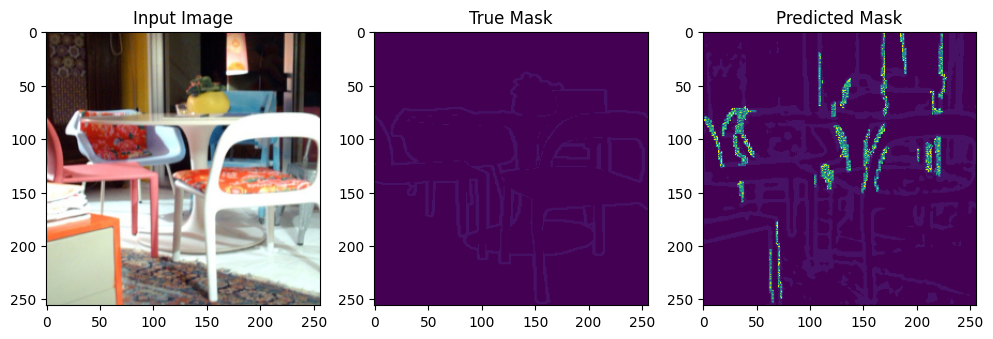

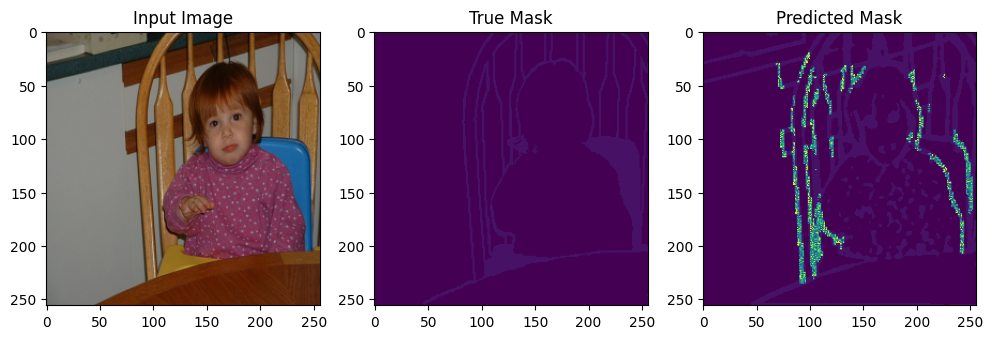

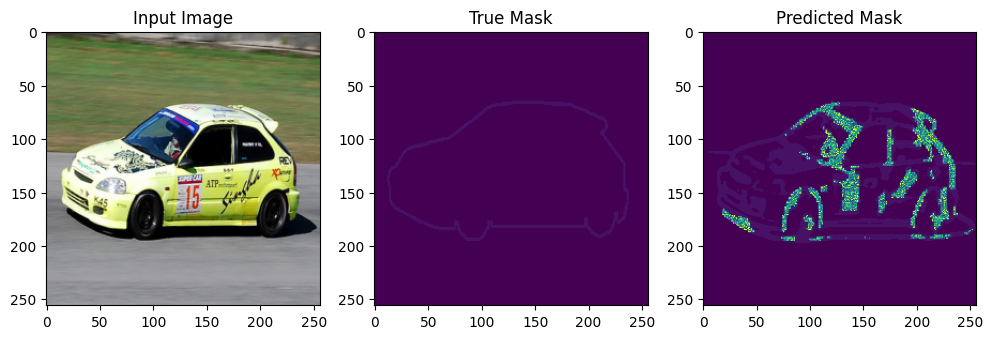

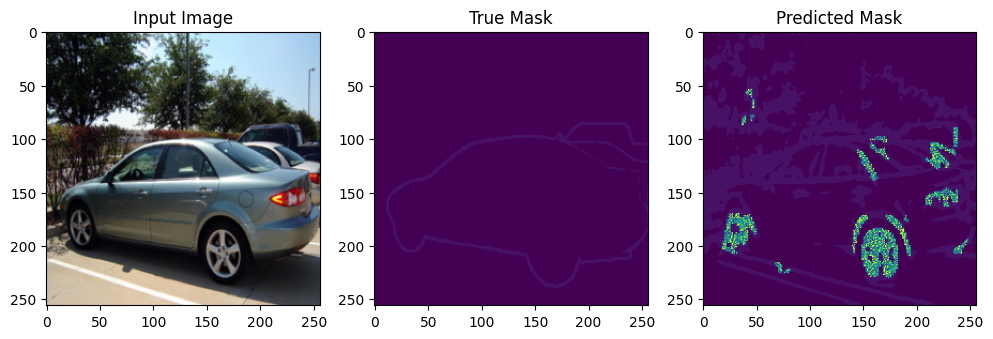

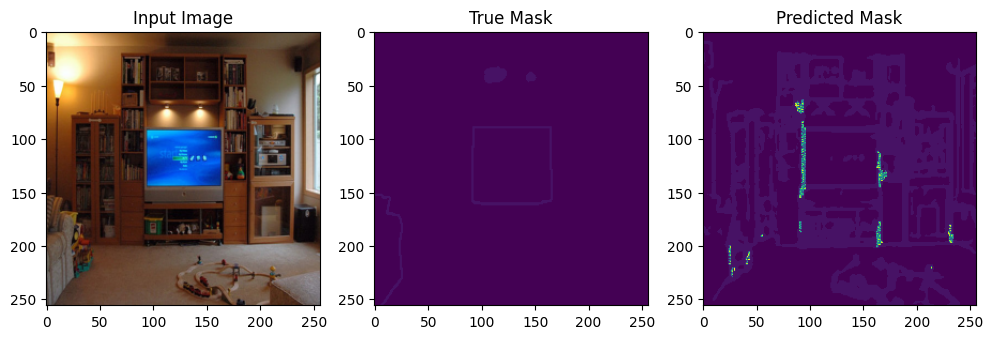

In [59]:
import torchvision.transforms.functional as TF

def inverse_normalize(image, mean, std):
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )
    return inv_normalize(image)

# Set your model to evaluation mode
model.eval()

# Choose a few samples for prediction from the validation dataset
num_samples = 5
sample_loader = torch.utils.data.DataLoader(voc_val, batch_size=num_samples, shuffle=True)
sample_images, sample_labels = next(iter(sample_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

# Make predictions
with torch.no_grad():
    model_outputs = model(sample_images)

# Convert predictions to class labels
_, predicted_labels = torch.max(model_outputs, 1)

for i in range(num_samples):
    # Convert tensors to numpy arrays
    input_image = inverse_normalize(sample_images[i].cpu(), mean, std).permute(1, 2, 0).numpy()
    true_mask = sample_labels[i].cpu().numpy().squeeze()  # Remove singleton dimension
    predicted_mask = predicted_labels[i].cpu().numpy().squeeze()  # Remove singleton dimension

    # Display the images and masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask,  vmin=0, vmax=out_channels - 1)
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, vmin=0, vmax=out_channels - 1)
    plt.title('Predicted Mask')

    plt.show()

In [104]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # Register mean and std as buffers
        self.register_buffer('mean', mean.reshape(1, -1, 1, 1))
        self.register_buffer('std', std.reshape(1, -1, 1, 1))

    def forward(self, x):
        return (x - self.mean) / self.std
"""
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        mid_channels = out_channels // 3

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels, out_channels - 2 * mid_channels, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv3_out = self.conv3(x)
        conv5_out = self.conv5(x)
        return torch.cat([conv1_out, conv3_out, conv5_out], dim=1)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, last=False):
        super().__init__()
        if last is False:
            self.double_conv = nn.Sequential(
                InceptionBlock(in_channels, out_channels),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                InceptionBlock(out_channels, out_channels),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.double_conv = nn.Sequential(
                InceptionBlock(in_channels, mid_channels),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                InceptionBlock(mid_channels, out_channels),
                nn.BatchNorm2d(out_channels),
                nn.Sigmoid()
            )

        print(f"Expected: {in_channels} -> {out_channels}")

    def forward(self, x):
        return self.double_conv(x)"""

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        mid_channels = out_channels // 3

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels, mid_channels, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv3_out = self.conv3(x)
        conv5_out = self.conv5(x)

        print(f'Input shape: {x.shape}, Conv1 output shape: {conv1_out.shape}, Conv3 output shape: {conv3_out.shape}, Conv5 output shape: {conv5_out.shape}')

        return torch.cat([conv1_out, conv3_out, conv5_out], dim=1)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, last=False):
        super().__init__()
        if last is False:
            self.double_conv = nn.Sequential(
                InceptionBlock(in_channels, mid_channels),
                nn.BatchNorm2d(mid_channels * 3),
                nn.ReLU(inplace=True),
                InceptionBlock(mid_channels * 3, out_channels),
                nn.BatchNorm2d(out_channels * 3),
                nn.ReLU(inplace=True)
            )
        else:
            self.double_conv = nn.Sequential(
                InceptionBlock(in_channels, mid_channels),
                nn.BatchNorm2d(mid_channels * 3),
                nn.ReLU(inplace=True),
                InceptionBlock(mid_channels * 3, out_channels // 3),
                nn.BatchNorm2d(out_channels),  # Update to match the expected number of channels
                nn.Sigmoid()
            )

        print(f"Expected : {mid_channels * 3} -> {out_channels}")

    def forward(self, x):
        return self.double_conv(x)



class UNet_Inception(nn.Module):
    def __init__(self, in_channels, out_channels, channel_list, means=None, stds=None):
        super().__init__()
        if means is None:
            means = torch.tensor([0.0 for _ in range(in_channels)])
        if stds is None:
            stds = torch.tensor([1.0 for _ in range(in_channels)])
        self.normalize = Normalize(mean=means, std=stds)
        self.downs = nn.ModuleList()
        curr_channel = in_channels
        for intermediate_channel in channel_list:
            self.downs.append(DoubleConv(curr_channel, intermediate_channel, intermediate_channel))
            curr_channel = intermediate_channel

        self.bottleneck = DoubleConv(curr_channel, curr_channel * 2, curr_channel)

        self.ups = nn.ModuleList()
        for i in reversed(range(len(channel_list))):
            if i - 1 < 0:
                self.ups.append(DoubleConv(channel_list[i], channel_list[i], out_channels, last=True))
            else:
                self.ups.append(DoubleConv(channel_list[i], channel_list[i], channel_list[i - 1]))
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        x = self.normalize(x)
        pool_outs = []
        down_activations = []
        for down in self.downs:
            x = down(x)
            down_activations.append(x)

            x, indices = self.pool(x)
            pool_outs.append(indices)

        x = self.bottleneck(x)
        for index, up in enumerate(self.ups):
            x = self.unpool.forward(x, pool_outs[-index - 1])
            temp = x + down_activations[-index - 1]
            x = up(temp)
        return x

In [105]:
# Define your UNet model
in_channels = 3  # Assuming RGB images
out_channels = 21  # Number of classes in Pascal VOC
channel_list = [64, 128, 256, 512]  # Adjust as needed
model = UNet_Inception(in_channels, out_channels, channel_list)
#model = UNet(in_channels, out_channels)



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10  # Adjust as needed
# writer = SummaryWriter()  # For TensorBoard logging
global_step = 0




for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        print(f"Input shape: {images.shape}")
        print(f"Labels shape: {labels.squeeze(1).long().shape}")

        optimizer.zero_grad()

        outputs = model(images)

        print(f"Output shape: {outputs.shape}")


        loss = criterion(outputs, labels.squeeze(1).long())  # Assuming labels are 3D (batch_size, 1, height, width)
        #loss = criterion(outputs, labels.unsqueeze(1).long())  # Add unsqueeze to make labels 4D

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate IoU
        outputs = torch.argmax(outputs, dim=1)
        iou = calculate_iou(outputs, labels.squeeze(1).long())
        total_iou += iou

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_loss}, Average Training IoU: {avg_iou}')


    # Validation loop
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc=f'Validation'):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels.squeeze(1).long()).item()

            # Calculate IoU
            val_outputs = torch.argmax(val_outputs, dim=1)
            iou = calculate_iou(val_outputs, val_labels.squeeze(1).long())
            val_iou += iou

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {avg_val_loss}, Average Validation IoU: {avg_val_iou}')

Expected : 192 -> 64
Expected : 384 -> 128
Expected : 768 -> 256
Expected : 1536 -> 512
Expected : 3072 -> 512
Expected : 1536 -> 256
Expected : 768 -> 128
Expected : 384 -> 64
Expected : 192 -> 21


Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

Input shape: torch.Size([16, 3, 256, 256])
Labels shape: torch.Size([16, 256, 256])
Input shape: torch.Size([16, 3, 256, 256]), Conv1 output shape: torch.Size([16, 21, 256, 256]), Conv3 output shape: torch.Size([16, 21, 256, 256]), Conv5 output shape: torch.Size([16, 21, 256, 256])


RuntimeError: ignored

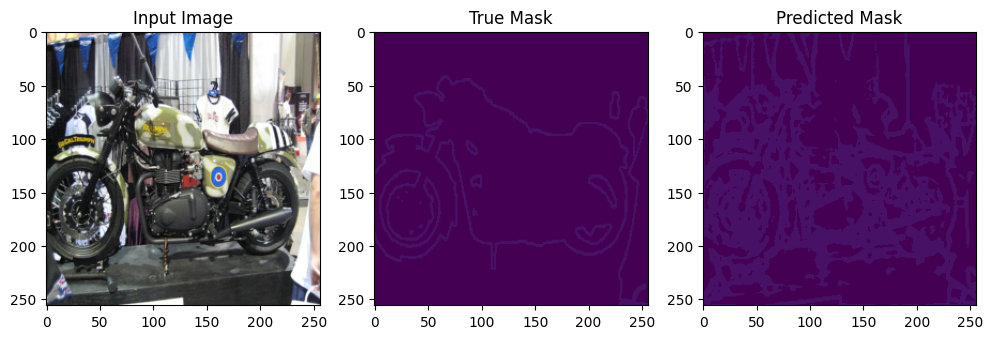

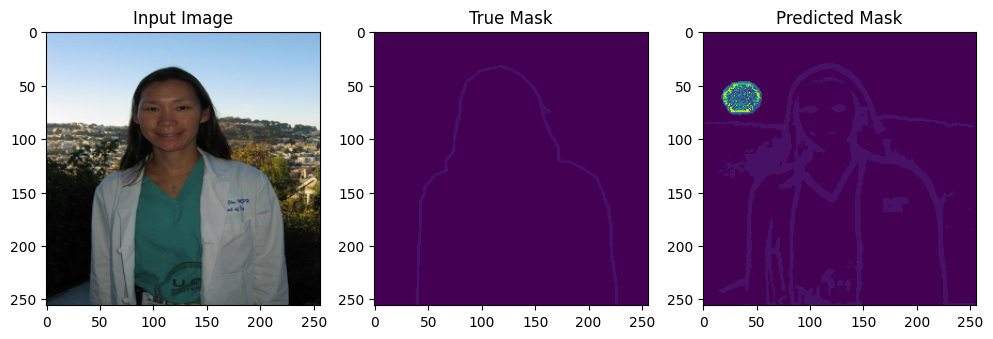

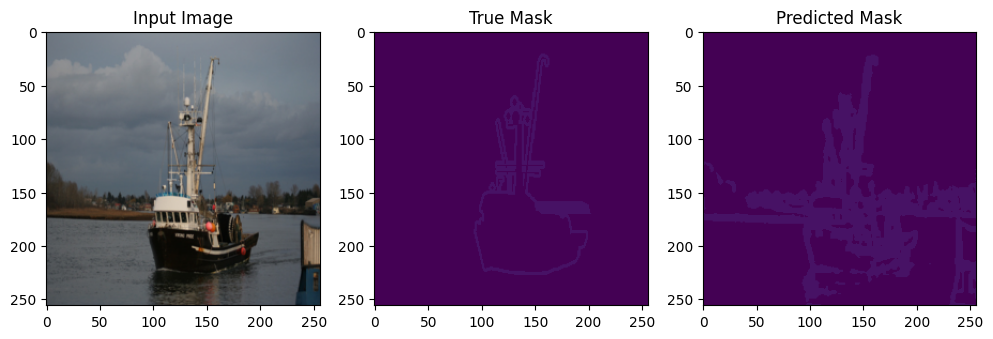

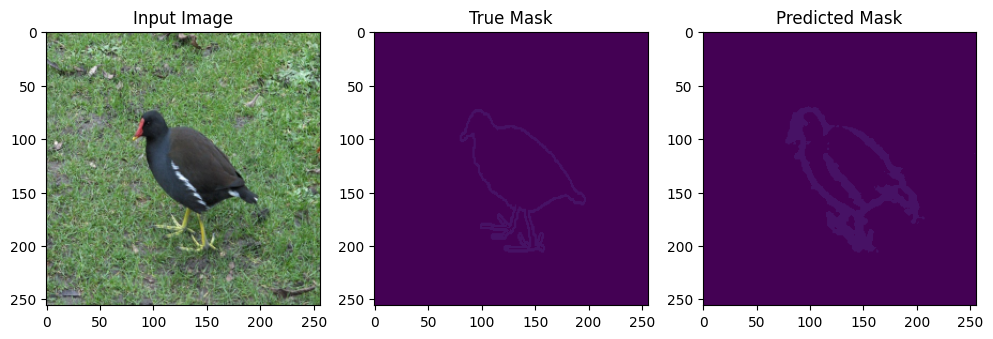

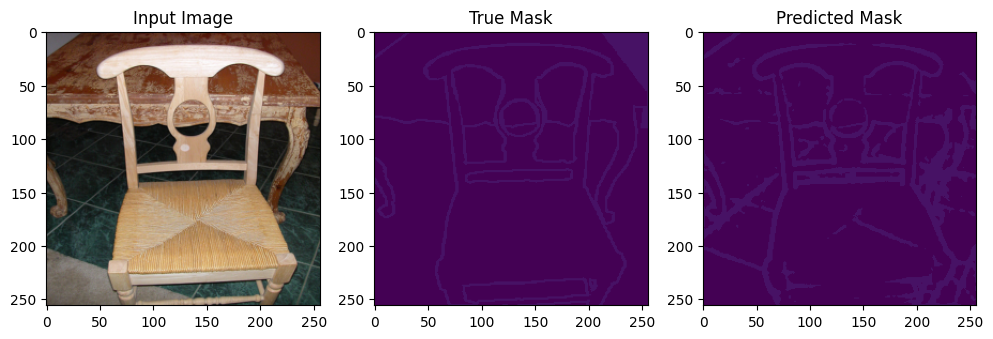

In [99]:
import torchvision.transforms.functional as TF

def inverse_normalize(image, mean, std):
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )
    return inv_normalize(image)

# Set your model to evaluation mode
model.eval()

# Choose a few samples for prediction from the validation dataset
num_samples = 5
sample_loader = torch.utils.data.DataLoader(voc_val, batch_size=num_samples, shuffle=True)
sample_images, sample_labels = next(iter(sample_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

# Make predictions
with torch.no_grad():
    model_outputs = model(sample_images)

# Convert predictions to class labels
_, predicted_labels = torch.max(model_outputs, 1)

for i in range(num_samples):
    # Convert tensors to numpy arrays
    input_image = inverse_normalize(sample_images[i].cpu(), mean, std).permute(1, 2, 0).numpy()
    true_mask = sample_labels[i].cpu().numpy().squeeze()  # Remove singleton dimension
    predicted_mask = predicted_labels[i].cpu().numpy().squeeze()  # Remove singleton dimension

    # Display the images and masks
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask,  vmin=0, vmax=out_channels - 1)
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, vmin=0, vmax=out_channels - 1)
    plt.title('Predicted Mask')

    plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np

# Define a simple fully convolutional network (FCN) model
class SimpleFCN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# Calculate Intersection over Union (IoU)
def calculate_iou(predictions, targets):
    intersection = torch.logical_and(predictions, targets).sum().item()
    union = torch.logical_or(predictions, targets).sum().item()
    iou = intersection / union if union > 0 else 0.0
    return iou

# Hyperparameters
num_classes = 21  # Including background
batch_size = 8
learning_rate = 0.001
num_epochs = 5

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load PASCAL VOC segmentation dataset
train_dataset = VOCSegmentation(root='./', year='2012', image_set='train', download=True, transform=transform)
test_dataset = VOCSegmentation(root='./', year='2012', image_set='val', download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimpleFCN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)





Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./


In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

def custom_collate(batch):
    """
    Custom collate function to handle PIL Image objects in the batch.
    """
    images, masks = zip(*batch)

    # Check if images are already tensors, if not, apply ToTensor transformation
    images = torch.stack([img if isinstance(img, torch.Tensor) else transforms.ToTensor()(img) for img in images])
    masks = torch.stack([mask if isinstance(mask, torch.Tensor) else transforms.ToTensor()(mask) for mask in masks])

    return {'image': images, 'mask': masks}


# Example usage in your DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [24]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}')

# Testing loop
model.eval()
total_iou = 0.0

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        # Calculate IoU for the batch
        batch_iou = calculate_iou(predictions, targets)
        total_iou += batch_iou

        # Visualize results for the first batch (adjust as needed)
        if batch_iou > 0.5:  # Display only if IoU is above a threshold
            plt.figure(figsize=(12, 4))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(inputs[0].permute(1, 2, 0))
            plt.title('Original Image')
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(targets[0], cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Ground Truth Mask')
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[0], cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()

# Calculate average IoU
average_iou = total_iou / len(test_loader)
print(f'Average IoU on Test Set: {average_iou:.4f}')

RuntimeError: ignored

In [27]:
from torch.utils.data import DataLoader

# Assuming you have a dataset named 'train_dataset' with your custom PascalVOC class

def custom_collate(batch):
    images, masks = zip(*batch)

    # Convert PIL Images to Tensors
    images = torch.stack([transforms.ToTensor()(img) for img in images])
    masks = torch.stack([transforms.ToTensor()(mask) for mask in masks])

    return {'image': images, 'mask': masks}



In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from tqdm import tqdm
from sklearn.metrics import jaccard_score

# Define FCN model
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Fully Convolutional Layer
        self.fcn = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fcn(x)
        return x

# Define U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        # Define your U-Net architecture here

    def forward(self, x):
        # Forward pass logic for U-Net
        return x

# Function to calculate IoU
def calculate_iou(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum().item()
    union = (pred + target - pred * target).sum().item()
    iou = intersection / union if union != 0 else 0.0
    return iou

# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        inputs, targets = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

# Function to test the model
def test(model, test_loader, device):
    model.eval()
    total_iou = 0.0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs, targets = batch['image'].to(device), batch['mask'].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

            iou = calculate_iou(predictions, targets)
            total_iou += iou

    return total_iou / len(test_loader)

# Hyperparameters
batch_size = 8
num_epochs = 10
learning_rate = 0.001
num_classes = 21  # Including background

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load PASCAL VOC dataset
train_dataset = VOCSegmentation(root='./', year='2012', image_set='train', download=True, transform=transform)
test_dataset = VOCSegmentation(root='./', year='2012', image_set='val', download=True, transform=transform)

# Create data loaders
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage in your DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models, optimizers, and loss functions
fcn_model = FCN(num_classes).to(device)
#unet_model = UNet(num_classes).to(device)

fcn_optimizer = optim.Adam(fcn_model.parameters(), lr=learning_rate)
#unet_optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

# Training and testing loops
for epoch in range(num_epochs):
    # Training
    fcn_loss = train(fcn_model, train_loader, criterion, fcn_optimizer, device)
    #unet_loss = train(unet_model, train_loader, criterion, unet_optimizer, device)

    # Testing
    fcn_iou = test(fcn_model, test_loader, device)
    #unet_iou = test(unet_model, test_loader, device)

    # Print results
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"FCN Loss: {fcn_loss:.4f}, FCN IoU: {fcn_iou:.4f}")
    print(f"U-Net Loss: {unet_loss:.4f}, U-Net IoU: {unet_iou:.4f}")
    print("-" * 50)

# Note: This code is a template, and you need to complete the model architecture for FCN and U-Net and adjust hyperparameters accordingly.


Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to ./


Training:   0%|          | 0/183 [00:00<?, ?it/s]


TypeError: ignored

### Get PASCAL Data

In [29]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar


--2023-12-04 00:18:27--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar.1’

VOCtrainval_11-May- 100%[===================>]   1.86G  17.0MB/s    in 2m 1s   

2023-12-04 00:20:29 (15.8 MB/s) - ‘VOCtrainval_11-May-2012.tar.1’ saved [1999639040/1999639040]



In [9]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split
from torchvision import transforms

class PascalVOC(Dataset):
    def __init__(self, root_dir, image_set='train', transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.mask_dir = os.path.join(root_dir, 'SegmentationClass')
        self.image_list_file = os.path.join(root_dir, f'ImageSets/Segmentation/{image_set}.txt')
        self.transform = transform

        with open(self.image_list_file, 'r') as file:
            self.image_list = [line.strip() for line in file]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f'{self.image_list[idx]}.jpg')
        mask_name = os.path.join(self.mask_dir, f'{self.image_list[idx]}.png')

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')

        if self.transform:
            # Apply transformations to the image
            image = self.transform['image'](image)

            # Apply transformations to the mask
            mask = self.transform['mask'](mask)

        return {'image': image, 'mask': mask}

    def split_dataset(self, train_ratio=0.8, shuffle=True, random_seed=None):
        dataset_size = len(self)
        train_size = int(train_ratio * dataset_size)
        test_size = dataset_size - train_size

        indices = list(range(dataset_size))
        if shuffle:
            if random_seed is not None:
                torch.manual_seed(random_seed)
            indices = torch.randperm(dataset_size).tolist()

        train_indices = indices[:train_size]
        test_indices = indices[train_size:]

        train_dataset = torch.utils.data.Subset(self, train_indices)
        test_dataset = torch.utils.data.Subset(self, test_indices)

        return train_dataset, test_dataset

dataset = PascalVOC(root_dir='./VOCdevkit/VOC2012', image_set='train')
train, test = dataset.split_dataset(train_ratio=0.8, shuffle=True, random_seed=42)


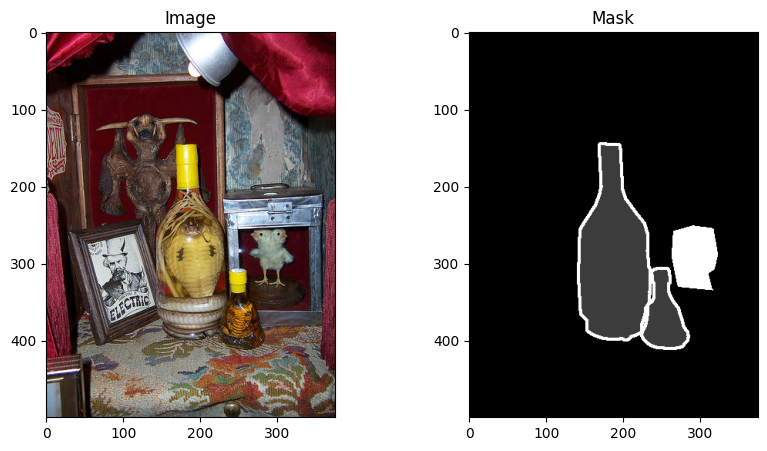

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

def visualize_sample(sample):
    image = sample['image']
    mask = sample['mask']

    # Convert to NumPy arrays if they are PyTorch tensors
    if torch.is_tensor(image):
        image = F.to_pil_image(image)
    if torch.is_tensor(mask):
        mask = F.to_pil_image(mask)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.show()

visualize_sample(train[10])


## Original U-Net

In [11]:
# https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out


In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim

BATCH_SIZE =  64

# Define separate transformations for image and mask
transform = {
    'image': transforms.Compose([
        transforms.Resize((572, 572)),
        transforms.ToTensor(),
    ]),
    'mask': transforms.Compose([
        transforms.Resize((572, 572)),
        transforms.ToTensor(),
    ]),
}


dataset = PascalVOC(root_dir='./VOCdevkit/VOC2012', image_set='train', transform=transform)
train_dataset, test_dataset = dataset.split_dataset(train_ratio=0.8, shuffle=True, random_seed=42)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
# Initialize the model, loss function, and optimizer
model = UNet(n_class=20)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the specified device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# Create instances of the dataset
train_dataset = PascalVOC(root_dir='./VOCdevkit/VOC2012', image_set='train', transform=transform)

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs = batch['image']
        masks = batch['mask']

        # Move inputs and masks to the specified device
        inputs, masks = inputs.to(device), masks.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


OutOfMemoryError: ignored

In [8]:
# Initialize the model, loss function, and optimizer
model = UNet(n_class=20)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    for batch in train_loader:
        inputs = batch['image']
        masks = batch['mask']

        inputs, masks = inputs.to(device), masks.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

RuntimeError: ignored

## Modified U-Net

In [3]:
import torch
from torch import nn


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # Register mean and std as buffers
        self.register_buffer('mean', mean.reshape(1, -1, 1, 1))
        self.register_buffer('std', std.reshape(1, -1, 1, 1))

    def forward(self, x):
        return (x - self.mean) / self.std


class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, last=False):
        super().__init__()
        if last is False:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, (3, 3), (1, 1), 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Sigmoid()
            )

    def forward(self, x):
        # x should (N, C, H, W)
        return self.double_conv(x)


class UNet(nn.Module):
    """Unet inspired architecture.
    Using same convolutions, with output channels being equal to the number of classes. Adding instead of
    appending. Upsampling with MaxUnpooling instead of transpose convolutions.

    Attributes:
        in_channels: The number of input channels.
        out_channels: The number of output classes (including background).
        channel_list: A list representing the intermediate channels that we have. The bottleneck (bottom of the U) outputs 2 * the last channel.
    """

    def __init__(self, in_channels, out_channels, channel_list, means=None, stds=None):
        super().__init__()
        if means is None:
            means = torch.tensor([0.0 for _ in range(in_channels)])
        if stds is None:
            stds = torch.tensor([1.0 for _ in range(in_channels)])
        self.normalize = Normalize(mean=means, std=stds)
        self.downs = nn.ModuleList()
        curr_channel = in_channels
        for intermediate_channel in channel_list:
            self.downs.append(DoubleConv(curr_channel, intermediate_channel, intermediate_channel))
            curr_channel = intermediate_channel

        self.bottleneck = DoubleConv(curr_channel, curr_channel * 2, curr_channel)

        self.ups = nn.ModuleList()
        for i in reversed(range(len(channel_list))):
            if i - 1 < 0:
                self.ups.append(DoubleConv(channel_list[i], channel_list[i], out_channels, last=True))
            else:
                self.ups.append(DoubleConv(channel_list[i], channel_list[i], channel_list[i - 1]))
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        x = self.normalize(x)
        pool_outs = []
        down_activations = []
        for down in self.downs:
            x = down(x)
            down_activations.append(x)

            x, indices = self.pool(x)
            pool_outs.append(indices)

        x = self.bottleneck(x)
        for index, up in enumerate(self.ups):
            x = self.unpool.forward(x, pool_outs[-index - 1])
            temp = x + down_activations[-index - 1]
            x = up(temp)
        return x